# CIFAR-10: Part 1
In this two-part tutorial, we present an end-to-end example of training and using a convolutional neural network for a classic image recognition problem. We will use the CIFAR-10 benchmark dataset, which is a 10-class dataset consisting of 60,000 color images of size 32x32. We will use a .png version of the dataset to emulate the use of a custom dataset that you might find in the wild. The specific items that this tutorial will cover are as follows:

### Part 1:
- Download dataset
- Write images to lmdbs
- Define and train a model with checkpoints
- Save the trained model

### Part 2:
- Load pre-trained model from Part 1
- Run inference on testing lmdb
- Run inference on single .png image
- Continue training from checkpoint


Let's start with some necessary imports.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
import lmdb
import shutil
from imageio import imread
import caffe2.python.predictor.predictor_exporter as pe
from caffe2.proto import caffe2_pb2
from caffe2.python.predictor import mobile_exporter
from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

Necessities imported!


### Download and unpack dataset if necessary
Now let's download the dataset from [Joseph Redmon](https://pjreddie.com/)'s CIFAR-10 dataset mirror and extract the data from the tarball. Note that this file is fairly large, so it may take a few minutes to download/unpack.

In [ ]:
import requests
import tarfile

# Set paths and variables
# data_folder is where the data is downloaded and unpacked
data_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_data', 'cifar10')
# root_folder is where checkpoint files and .pb model definition files will be outputted
root_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_files', 'tutorial_cifar10')

url = "http://pjreddie.com/media/files/cifar.tgz"   # url to data
filename = url.split("/")[-1]                       # download file name
download_path = os.path.join(data_folder, filename) # path to extract data to

# Create data_folder if not already there
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)

# If data does not already exist, download and extract
if not os.path.exists(download_path.strip('.tgz')):
    # Download data
    r = requests.get(url, stream=True)
    print("Downloading... {} to {}".format(url, download_path))
    open(download_path, 'wb').write(r.content)
    print("Finished downloading...")

    # Unpack images from tgz file
    print('Extracting images from tarball...')
    tar = tarfile.open(download_path, 'r')
    for item in tar:
        tar.extract(item, data_folder)
    print("Completed download and extraction!")
    
else:
    print("Image directory already exists. Moving on...")

Let's take a peek at a few training images to get an idea of what we're dealing with.

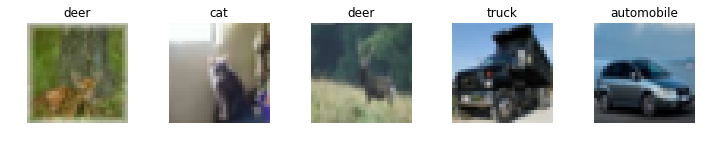

In [3]:
import glob

# Grab 5 image paths from training set to display
sample_imgs = glob.glob(os.path.join(data_folder, "cifar", "train") + '/*.png')[:5]

# Plot images
f, ax = plt.subplots(1, 5, figsize=(10,10))
plt.tight_layout()
for i in range(5):
    ax[i].set_title(sample_imgs[i].split("_")[-1].split(".")[0])
    ax[i].axis('off')
    ax[i].imshow(imread(sample_imgs[i]).astype(np.uint8)) 

### Create label files and write LMDBs
Now that we have our data, we need to write LMDBs for training, validation, and testing. To separate what images we want in each category, we will employ a similar technique to what was often used in the original Caffe framework: creating label files.

Label files are text files that map each .png image to its class.

    /path/to/im1.png 7
    /path/to/im2.png 3
    /path/to/im3.png 5
    /path/to/im4.png 0
    ...
    
The process of creating these label files will likely be different for every dataset you will encounter. It really depends on how the data is labeled in the original format of the download. In the case of the CIFAR-10 .png download:

- cifar/labels.txt is a list of the 10 labels in their string form (airplane, automobile, bird, ...)
- cifar/train/ is a directory of 50,000 labeled training images that contain their string label name in the filename (0_frog.png, 1_truck.png, 2_truck.png)
- cifar/test/ is a directory of 10,000 testing images that are labeled the same way as the images in cifar/train/

Using this information, let's start by creating label files to make life easier before writing to LMDBs.

The first step to doing this is to declare our path variables, and create a `classes` dictionary to map string labels to integer labels that the LMDBs will take.

In [4]:
# Paths to train and test directories
training_dir_path = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_data', 'cifar10', 'cifar', 'train')
testing_dir_path = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_data', 'cifar10', 'cifar', 'test')

# Paths to label files
training_labels_path = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_data', 'cifar10', 'training_dictionary.txt')
validation_labels_path = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_data', 'cifar10', 'validation_dictionary.txt')
testing_labels_path = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_data', 'cifar10', 'testing_dictionary.txt')

# Paths to LMDBs
training_lmdb_path = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_data', 'cifar10', 'training_lmdb')
validation_lmdb_path = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_data', 'cifar10', 'validation_lmdb')
testing_lmdb_path = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_data', 'cifar10', 'testing_lmdb')

# Path to labels.txt
labels_path = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks', 'tutorial_data', 'cifar10', 'cifar', 'labels.txt')

# Open label file handler
labels_handler = open(labels_path, "r")


# Create classes dictionary to map string labels to integer labels
classes = {}
i = 0
lines = labels_handler.readlines()
for line in sorted(lines):
    line = line.rstrip()
    classes[line] = i
    i += 1
labels_handler.close()

print("classes:", classes)

classes: {'horse': 7, 'automobile': 1, 'deer': 4, 'dog': 5, 'frog': 6, 'cat': 3, 'truck': 9, 'ship': 8, 'airplane': 0, 'bird': 2}


Now that we have our `classes` dictionary to map string labels to integer labels, we can write our label files for training, validation, and testing. We will split the data as follows:

    - training: 44,000 images (73%)
    - validation: 6,000 images (10%)
    - testing: 10,000 images (17%)
    
Note that the validation images are simply a subset of our training images that we will withhold to periodically test with during training. We do this so we can see how well our network is doing on unseen images without exposing our testing images to the model during training; something that makes machine learning experts cringe.

To help get a relatively even distribution of each class of image in the training and validation sets, we first read all of the images (full paths) from the training directory into an array called `imgs`, and shuffle this list before iterating over it to write our label files.

In [5]:
from random import shuffle

# Open file handlers
training_labels_handler = open(training_labels_path, "w")
validation_labels_handler = open(validation_labels_path, "w")
testing_labels_handler = open(testing_labels_path, "w")


# Create training, validation, and testing label files
i = 0
validation_count = 6000
imgs = glob.glob(training_dir_path + '/*.png')  # read all training images into array
shuffle(imgs)  # shuffle array
for img in imgs:
    # Write first 6,000 image paths, followed by their integer label, to the validation label files
    if i < validation_count:
        validation_labels_handler.write(img + ' ' + str(classes[img.split('_')[-1].split('.')[0]]) + '\n')
    # Write the remaining to the training label files
    else:
        training_labels_handler.write(img + ' ' + str(classes[img.split('_')[-1].split('.')[0]]) + '\n')
    i += 1
print("Finished writing training and validation label files")

# Write our testing label files using the testing images
for img in glob.glob(testing_dir_path + '/*.png'):
    testing_labels_handler.write(img + ' ' + str(classes[img.split('_')[-1].split('.')[0]]) + '\n')
print("Finished writing testing label files")

# Close file handlers
training_labels_handler.close()
validation_labels_handler.close()
testing_labels_handler.close()

Finished writing training and validation label files
Finished writing testing label files


We are now ready to use these label files to write our LMDBs. The following code is adapted from Caffe2's [lmdb_create_example.py](https://github.com/caffe2/caffe2/blob/master/caffe2/python/examples/lmdb_create_example.py) script. Note that before feeding the image data to the LMDB, we first reorder color channels from RGB --> BGR, and reorder columns from HWC --> CHW.

If you have gone through the *Image Pre-Processing Pipeline* tutorial, you know that Caffe2 expects inputs in NCHW format, where N stands for the number of images in a batch. Don't worry, we'll add this N dimension when we define the data layer to our model (see `AddInput` below).

In [ ]:
def write_lmdb(labels_file_path, lmdb_path):
    labels_handler = open(labels_file_path, "r")
    # Write to lmdb
    print(">>> Write database...")
    LMDB_MAP_SIZE = 1 << 40
    print("LMDB_MAP_SIZE", LMDB_MAP_SIZE)
    env = lmdb.open(lmdb_path, map_size=LMDB_MAP_SIZE)

    with env.begin(write=True) as txn:
        count = 0
        for line in labels_handler.readlines():
            line = line.rstrip()
            im_path = line.split()[0]
            im_label = int(line.split()[1])
            
            # read in image (as RGB)
            img_data = imread(im_path).astype(np.float32)
            
            # convert to BGR
            img_data = img_data[:, :, (2, 1, 0)]
            
            # HWC -> CHW (N gets added in AddInput function)
            img_data = np.transpose(img_data, (2,0,1))
            
            # Create TensorProtos
            tensor_protos = caffe2_pb2.TensorProtos()
            img_tensor = tensor_protos.protos.add()
            img_tensor.dims.extend(img_data.shape)
            img_tensor.data_type = 1
            flatten_img = img_data.reshape(np.prod(img_data.shape))
            img_tensor.float_data.extend(flatten_img)
            label_tensor = tensor_protos.protos.add()
            label_tensor.data_type = 2
            label_tensor.int32_data.append(im_label)
            txn.put(
                '{}'.format(count).encode('ascii'),
                tensor_protos.SerializeToString()
            )
            if ((count % 1000 == 0)):
                print("Inserted {} rows".format(count))
            count = count + 1

    print("Inserted {} rows".format(count))
    print("\nLMDB saved at " + lmdb_path + "\n\n")
    labels_handler.close()

    
# Call function to write our LMDBs
if not os.path.exists(training_lmdb_path):
    print("Writing training LMDB")
    write_lmdb(training_labels_path, training_lmdb_path)
else:
    print(training_lmdb_path, "already exists!")
if not os.path.exists(validation_lmdb_path):
    print("Writing validation LMDB")
    write_lmdb(validation_labels_path, validation_lmdb_path)
else:
    print(validation_lmdb_path, "already exists!")
if not os.path.exists(testing_lmdb_path):
    print("Writing testing LMDB")
    write_lmdb(testing_labels_path, testing_lmdb_path)
else:
    print(testing_lmdb_path, "already exists!")

### Define our CNN model
Now that we have our data formatted in LMDBs, it is time to define our model! 

First let's set some path variables, define dataset-specific parameters, and declare model training parameters. This is where we will set the number of training iterations that we want, as well as the batch sizes and validation interval to use. Feel free to come back and tinker with these parameters to see how it effects training and efficiency.

In [7]:
# Paths to the init & predict net output locations
init_net_out = 'cifar10_init_net.pb'
predict_net_out = 'cifar10_predict_net.pb'

# Dataset specific params
image_width = 32                # input image width
image_height = 32               # input image height
image_channels = 3              # input image channels (3 for RGB)
num_classes = 10                # number of image classes

# Training params
training_iters = 5000           # total training iterations
training_net_batch_size = 100   # batch size for training
validation_images = 6000        # total number of validation images
validation_interval = 100       # validate every <validation_interval> training iterations
checkpoint_iters = 1000         # output checkpoint db every <checkpoint_iters> iterations

Create the root_folder directory if it does not already exist. Also, call `workspace.ResetWorkspace(root_folder)` to set the `root_folder` as the working directory of our workspace.

In [8]:
# Create root_folder if not already there
if not os.path.isdir(root_folder):
    os.makedirs(root_folder)

# Resetting workspace with root_folder argument sets root_folder as working directory
workspace.ResetWorkspace(root_folder)

True

The next task is to define some helper functions to modularize our code, and ultimately define our model similarly to the MNIST tutorial. We will use the `ModelHelper` class to define and represent our model, as well as to contain the model's parameter information. The `brew` module will be used to add layers to our CNN model. For more information about the `ModelHelper`+`brew` model creation paradigm, see the [docs](https://caffe2.ai/docs/brew.html).

>It is important to note that by calling these functions, we are *NOT* running any computation with our model. Instead, we are constructing the graph of operators that will ultimately dictate the calculations made as our data blobs propagate forward and backward through the network. 

The first helper function is `AddInput`, which adds the input (data) layer to our model. Note that the image data stored in our LMDBs requires some minor preprocessing before it is fed to our computational layers. First, we read in the raw image data and labels from the LMDB, which is of type `uint8` ([0, 255] pixel values). We then cast the data to type `float` and rescale the data to [0, 1] to promote faster convergence. Finally, we will call `model.StopGradient(data, data)` to prevent the gradient from being calculated any further in the backward pass.

One final point about the blob names in quotes:
- In the case of `"data_uint8"` and `"label"`, these are the names of the blobs associated with the DB input
- If the name is an *input* blob, this represents the blob name that the operator expects when ran
- If the name is an *output* blob, e.g. `"data"`, it represents the name of the output blob that the operator creates

In [9]:
def AddInput(model, batch_size, db, db_type):
    # load the data
    data_uint8, label = brew.db_input(
        model,
        blobs_out=["data_uint8", "label"],
        batch_size=batch_size,
        db=db,
        db_type=db_type,
    )
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

The next step is to implement our CNN model definition. The network architecture that we will use is based on the "quick" model used in the original Caffe's [cifar10 example](https://github.com/BVLC/caffe/tree/master/examples/cifar10). This model has 3 convolutional/pooling layers, and uses Rectified Linear Unit activations (ReLU). Don't be afraid to come back and alter the model by changing hyperparameters and/or adding and removing layers to see how it affects training convergence.

We will use the `update_dims` function as a helper to keep track of the dimensionality shrinkage that the convolutional and pooling layers cause. The dimensionality changes are as follows:

$$height_{out}=\frac{height_{in}-kernel+2*pad}{stride}+1$$

---

$$width_{out}=\frac{width_{in}-kernel+2*pad}{stride}+1$$

While this function is not necessary, we found that it is a easy strategy to avoid having to hand calculate the dimensionality changes of the data to provide to the penultimate fully connected layer. It also allows us to quickly change hyperparameters such as kernel size and not have to worry about the corresponding dimensionality alterations.



In [10]:
# Helper function for maintaining the correct height and width dimensions after
# convolutional and pooling layers downsample the input data
def update_dims(height, width, kernel, stride, pad):
    new_height = ((height - kernel + 2*pad)//stride) + 1
    new_width = ((width - kernel + 2*pad)//stride) + 1
    return new_height, new_width


def Add_Original_CIFAR10_Model(model, data, num_classes, image_height, image_width, image_channels):
    # Convolutional layer 1
    conv1 = brew.conv(model, data, 'conv1', dim_in=image_channels, dim_out=32, kernel=5, stride=1, pad=2)
    h,w = update_dims(height=image_height, width=image_width, kernel=5, stride=1, pad=2)
    # Pooling layer 1
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=3, stride=2)
    h,w = update_dims(height=h, width=w, kernel=3, stride=2, pad=0)
    # ReLU layer 1
    relu1 = brew.relu(model, pool1, 'relu1')
    
    # Convolutional layer 2
    conv2 = brew.conv(model, relu1, 'conv2', dim_in=32, dim_out=32, kernel=5, stride=1, pad=2)
    h,w = update_dims(height=h, width=w, kernel=5, stride=1, pad=2)
    # ReLU layer 2
    relu2 = brew.relu(model, conv2, 'relu2')
    # Pooling layer 1
    pool2 = brew.average_pool(model, relu2, 'pool2', kernel=3, stride=2)
    h,w = update_dims(height=h, width=w, kernel=3, stride=2, pad=0)
    
    # Convolutional layer 3
    conv3 = brew.conv(model, pool2, 'conv3', dim_in=32, dim_out=64, kernel=5, stride=1, pad=2)
    h,w = update_dims(height=h, width=w, kernel=5, stride=1, pad=2)
    # ReLU layer 3
    relu3 = brew.relu(model, conv3, 'relu3')
    # Pooling layer 3
    pool3 = brew.average_pool(model, relu3, 'pool3', kernel=3, stride=2)
    h,w = update_dims(height=h, width=w, kernel=3, stride=2, pad=0)
    
    # Fully connected layers
    fc1 = brew.fc(model, pool3, 'fc1', dim_in=64*h*w, dim_out=64)
    fc2 = brew.fc(model, fc1, 'fc2', dim_in=64, dim_out=num_classes)
    
    # Softmax layer
    softmax = brew.softmax(model, fc2, 'softmax')
    return softmax

Our next helper function is `AddTrainingOperators`. This function will be called by our train model to add a loss function and an optimization technique for learning. We will use an averaged cross entropy loss function between the model's softmax scores and the ground truth labels. We then add gradient operators to our model with respect to the loss that we previously calculated. Finally, we use the `build_sgd` function from Caffe2's `optimizer` class as our loss minimization function.

Feel free to tinker with the hyper-parameters of the `build_sgd` function and observe the change in convergence efficiency during training.

In [11]:
def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # Compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # Use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # Use stochastic gradient descent as optimization function
    optimizer.build_sgd(
        model,
        base_learning_rate=0.01,
        policy="fixed",
        momentum=0.9,
        weight_decay=0.004
    )

`AddAccuracy` adds an accuracy layer to a model using the `brew` module. This calculates the percentage of samples in a given batch whose top-1 softmax class matches the ground truth label class (i.e. percentage of samples in batch the model got right).

In [12]:
def AddAccuracy(model, softmax, label):
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

The next and final helper function is `AddCheckpoints`, which outputs a checkpoint db at a regular interval of iterations. A checkpoint is essentially a saved state of a model during the training process. Checkpoints are useful for quickly loading a trained or partially trained model in the future, and they are an invaluable insurance policy during very long training processes. Caffe2 checkpoints are akin to Caffe's periodically outputted .caffemodel files. We use `brew`'s `iter` operator to track iterations, and will save them as LMDBs.

It is important to note that when using checkpoints, you must be careful about attempting to overwrite checkpoints of the same name from a previous training process. If you attempt to overwrite a checkpoint db, the training process will error out. To deal with this, we will save the checkpoints in a uniquely named directory under our `root_folder`. This directory's name is based on the current system timestamp, to avoid duplication.

In [ ]:
import datetime

# Create uniquely named directory under root_folder to output checkpoints to
unique_timestamp = str(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
checkpoint_dir = os.path.join(root_folder, unique_timestamp)
os.makedirs(checkpoint_dir)
print("Checkpoint output location: ", checkpoint_dir)

# Add checkpoints to a given model
def AddCheckpoints(model, checkpoint_iters, db_type):
    ITER = brew.iter(train_model, "iter")
    train_model.Checkpoint([ITER] + train_model.params, [], db=os.path.join(unique_timestamp, "cifar10_checkpoint_%05d.lmdb"), db_type="lmdb", every=checkpoint_iters)

### Initialize models with ModelHelper

Now that we have created the necessary helper functions, it is time to actually initialize our training and validation models and use our functions to define the models' operator graphs. *Remember that we are not executing the models yet*.

First, we define the train model:

    (1) Initialize model with ModelHelper class
    (2) Add data layer with AddInput function
    (3) Add the Cifar10 model, which returns a softmax blob
    (4) Add training operators with AddTrainingOperators function; use softmax blob from (3)
    (5) Add periodic checkpoints with AddCheckpoints function

Next, we define the validation model, which is structurally the same, but is separated because its input data comes from a different LMDB, and uses a different batch size. We will build as follows:

    (1) Initialize model with ModelHelper class with init_params=False
    (2) Add data layer with AddInput function
    (3) Add the Cifar10 model, which returns a softmax blob
    (4) Add accuracy layer with AddAccuracy function; use softmax blob from (3)

Finally, we define the deploy model:

    (1) Initialize model with ModelHelper class with init_params=False
    (2) Add the Cifar10 model, which will expect input blob called "data"




In [14]:
arg_scope = {"order": "NCHW"}

# TRAINING MODEL
# Initialize with ModelHelper class
train_model = model_helper.ModelHelper(
    name="train_net", arg_scope=arg_scope)
# Add data layer from training_lmdb
data, label = AddInput(
    train_model, batch_size=training_net_batch_size,
    db=training_lmdb_path,
    db_type='lmdb')
# Add model definition, save return value to 'softmax' variable
softmax = Add_Original_CIFAR10_Model(train_model, data, num_classes, image_height, image_width, image_channels)
# Add training operators using the softmax output from the model
AddTrainingOperators(train_model, softmax, label)
# Add periodic checkpoint outputs to the model
AddCheckpoints(train_model, checkpoint_iters, db_type="lmdb")


# VALIDATION MODEL
# Initialize with ModelHelper class without re-initializing params
val_model = model_helper.ModelHelper(
    name="val_net", arg_scope=arg_scope, init_params=False)
# Add data layer from validation_lmdb
data, label = AddInput(
    val_model, batch_size=validation_images,
    db=validation_lmdb_path,
    db_type='lmdb')
# Add model definition, save return value to 'softmax' variable
softmax = Add_Original_CIFAR10_Model(val_model, data, num_classes, image_height, image_width, image_channels)
# Add accuracy operator
AddAccuracy(val_model, softmax, label)


# DEPLOY MODEL
# Initialize with ModelHelper class without re-initializing params
deploy_model = model_helper.ModelHelper(
    name="deploy_net", arg_scope=arg_scope, init_params=False)
# Add model definition, expect input blob called "data"
Add_Original_CIFAR10_Model(deploy_model, "data", num_classes, image_height, image_width, image_channels)

print("Training, Validation, and Deploy models all defined!")

Training, Validation, and Deploy models all defined!


### Run training

Finally, now that we have our models and their operator graphs defined, it is time to actually run the training process. Under the hood, we have defined our models as operator graphs that are serialized in protobuf format. The final step is to send these protobufs to Caffe2's C++ backend so that model objects can be built and executed. 

Recall that a `ModelHelper` model object has two nets:

- `param_init_net`: Contains parameters and initialization data

- `net`: Contains the main network (operator graph) that we just defined

Both of these nets must be run, and we must start with the `param_init_net`. Because this net only needs to be run once, we run it with the `workspace.RunNetOnce` function, which instantiates, runs, and immediately destructs the network. If we want to run a network multiple times, as we do in the case of our training and validation nets, we first create the net with `workspace.CreateNet`, and we can then run the net using `workspace.RunNet`. 

Note that when we call `workspace.RunNet` on the `train_model`, this runs the forward and backward pass with a batch from our training LMDB. Running the `val_model` runs a forward pass with a batch from our validation LMDB (which we set to be all of the images) and adds an accuracy layer that we will use to track model accuracy on our quasi-test data as we train.

In [15]:
import math

# Initialize and create the training network
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
# Initialize and create validation network
workspace.RunNetOnce(val_model.param_init_net)
workspace.CreateNet(val_model.net, overwrite=True)
# Placeholder to track loss and validation accuracy
loss = np.zeros(int(math.ceil(training_iters/validation_interval)))
val_accuracy = np.zeros(int(math.ceil(training_iters/validation_interval)))
val_count = 0
iteration_list = np.zeros(int(math.ceil(training_iters/validation_interval)))

# Now, we run the network (forward & backward pass)
for i in range(training_iters):
    workspace.RunNet(train_model.net)
    
    # Validate every <validation_interval> training iterations
    if (i % validation_interval == 0):
        print("Training iter: ", i)
        loss[val_count] = workspace.FetchBlob('loss')
        workspace.RunNet(val_model.net)
        val_accuracy[val_count] = workspace.FetchBlob('accuracy')
        print("Loss: ", str(loss[val_count]))
        print("Validation accuracy: ", str(val_accuracy[val_count]) + "\n")
        iteration_list[val_count] = i
        val_count += 1

Training iter:  0
Loss:  2.31307768822
Validation accuracy:  0.102666668594

Training iter:  100
Loss:  2.0006108284
Validation accuracy:  0.301666676998

Training iter:  200
Loss:  1.76712167263
Validation accuracy:  0.354000002146

Training iter:  300
Loss:  1.51130759716
Validation accuracy:  0.388500005007

Training iter:  400
Loss:  1.65002763271
Validation accuracy:  0.435833334923

Training iter:  500
Loss:  1.45283842087
Validation accuracy:  0.463833332062

Training iter:  600
Loss:  1.3938421011
Validation accuracy:  0.473833322525

Training iter:  700
Loss:  1.37778162956
Validation accuracy:  0.493666678667

Training iter:  800
Loss:  1.48311090469
Validation accuracy:  0.532666683197

Training iter:  900
Loss:  1.23695576191
Validation accuracy:  0.542333304882

Training iter:  1000
Loss:  1.28399050236
Validation accuracy:  0.548666656017

Training iter:  1100
Loss:  1.17744922638
Validation accuracy:  0.549499988556

Training iter:  1200
Loss:  1.13034057617
Validation a

Let's plot the validation accuracy vs. loss over the training iterations.

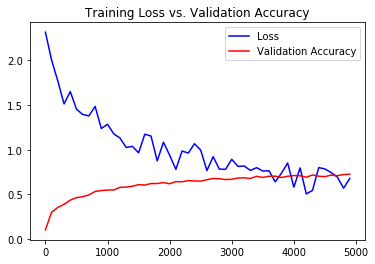

In [16]:
plt.title("Training Loss vs. Validation Accuracy")
plt.plot(iteration_list, loss, 'b')
plt.plot(iteration_list, val_accuracy, 'r')
plt.legend(('Loss', 'Validation Accuracy'), loc='upper right')

### Save trained model

Now that we have the parameters of the trained model in the workspace, we will export the deploy model using the `mobile_exporter` class. In Caffe2, pretrained models are commonly saved as two separate protobuf (.pb) files (init_net and predict_net). Models can also be saved in db formats, but we will save our model as protobuf files, as this is how they commonly appear in the Model Zoo.

For consistency, we'll save these in the same unique directory that the checkpoints are in.

In [ ]:
# Run init net and create main net
workspace.RunNetOnce(deploy_model.param_init_net)
workspace.CreateNet(deploy_model.net, overwrite=True)

# Use mobile_exporter's Export function to acquire init_net and predict_net
init_net, predict_net = mobile_exporter.Export(workspace, deploy_model.net, deploy_model.params)

# Locations of output files
full_init_net_out = os.path.join(checkpoint_dir, init_net_out)
full_predict_net_out = os.path.join(checkpoint_dir, predict_net_out)

# Simply write the two nets to file
with open(full_init_net_out, 'wb') as f:
    f.write(init_net.SerializeToString())
with open(full_predict_net_out, 'wb') as f:
    f.write(predict_net.SerializeToString())
print("Model saved as " + full_init_net_out + " and " + full_predict_net_out)

**Congratulations!** You have made it through Part 1 of the tutorial. In Part 2, we will load the model that we just trained and do all sorts of fun things like running inference on our testing LMDB, running inference on a given .png, and continuing training from one of our checkpoint outputs.

Thanks, and see you at Part 2!